# Buck Converter of step-down Convertor

In [1]:
from cursusdef import *

In dit hoofdstuk bespreken we de voedingen die een (eventueel veranderlijke) ingangsspanning omzetten in een stabiele en ook lagere uitgangsspanning. In het engels gebruiken we hiervoor typisch de volgende namen:
* [Buck converter](https://en.wikipedia.org/wiki/Buck_converter) 
* Step-down converter

## Zonder belasting van de uitgang

In [1]:
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Spice.Library import SpiceLibrary

def step_down(Vin = 12@u_V,Vout = 5@u_V,Iload = 2@u_A,frequency = 400@u_kHz,ripple_voltage = 50@u_mV,RL = 37@u_mΩ,ESR = 30@u_mΩ,ESL = 0,ripple_voltage_in = 200@u_mV,ESR_in = 120@u_mΩ,printdesignparameters=True):
    logger = Logging.setup_logging()
    #libraries_path = find_libraries()
   
    libraries_path = r'libraries' 
    spice_library = SpiceLibrary(libraries_path)
    circuit = Circuit('Buck Converter')

    circuit.include(spice_library['1N5822']) # Schottky diode
    circuit.include(spice_library['irf150'])

    ratio = Vout / Vin
    Rload = Vout / (.8 * Iload)
    period = frequency.period
    duty_cycle = ratio * period
    ripple_current = .3 * Iload # typically 30 %

    
    L = (Vin - Vout) * duty_cycle / ripple_current

    Cout = (ripple_current * duty_cycle) / (ripple_voltage - ripple_current * ESR)

    ripple_current_in = Iload / 2
    
    Cin = duty_cycle / (ripple_voltage_in / ripple_current_in - ESR_in)

    L = L.canonise()
    Cout = Cout.canonise()
    Cin = Cin.canonise()
    if printdesignparameters:
        print('ratio =', ratio)
        print('RLoad =', Rload)
        print('period =', period.canonise())
        print('duty_cycle =', duty_cycle.canonise())
        print('ripple_current =', ripple_current)
        print('L =', L)
        print('Cout =', Cout)
        print('Cint =', Cin)
    else:
        circuit.V('in', 'in', circuit.gnd, Vin)
        circuit.C('in', 'in', circuit.gnd, Cin)

        # Fixme: out drop from 12V to 4V
        # circuit.VCS('switch', 'gate', circuit.gnd, 'in', 'source', model='Switch', initial_state='off')
        # circuit.PulseVoltageSource('pulse', 'gate', circuit.gnd, 0@u_V, Vin, duty_cycle, period)
        # circuit.model('Switch', 'SW', ron=1@u_mΩ, roff=10@u_MΩ)

        # Fixme: Vgate => Vout ???
        circuit.X('Q', 'irf150', 'in', 'gate', 'source')
        # circuit.PulseVoltageSource('pulse', 'gate', 'source', 0@u_V, Vin, duty_cycle, period)
        circuit.R('gate', 'gate', 'clock', 1@u_Ω)
        circuit.PulseVoltageSource('pulse', 'clock', circuit.gnd, 0@u_V, 2.*Vin, duty_cycle, period)

        circuit.X('D', '1N5822', circuit.gnd, 'source')
        circuit.L(1, 'source', 1, L)
        circuit.R('L', 1, 'out', RL)
        circuit.C(1, 'out', circuit.gnd, Cout) # , initial_condition=0@u_V
        circuit.R('load', 'out', circuit.gnd, Rload)

        simulator = circuit.simulator(temperature=25, nominal_temperature=25)
        analysis = simulator.transient(step_time=period/300, end_time=period*150)

        figure, ax = plt.subplots(figsize=(20, 10))

        ax.plot(analysis.time,analysis.out, label='Vout [V]')
        ax.plot(analysis.time,analysis['source'],label='Vsource [V]')
        # ax.plot(analysis['source'] - analysis['out'])
        # ax.plot(analysis['gate'])
        ax.axhline(y=float(Vout), color='red')
        ax.legend( loc=(.8,.8))
        ax.grid()
        ax.set_xlabel('t [s]')
        ax.set_ylabel('[V]')

        plt.tight_layout()


step_down()

ratio = 0.4166666666666667 sr
RLoad = 3.125 Ω
period = 2.5000000000000004 μs
duty_cycle = 1.0416666666666667 μs
ripple_current = 0.6 A
L = 12.152777777777779 μH
Cout = 19.53125 μF
Cint = 13.020833333333332 μF


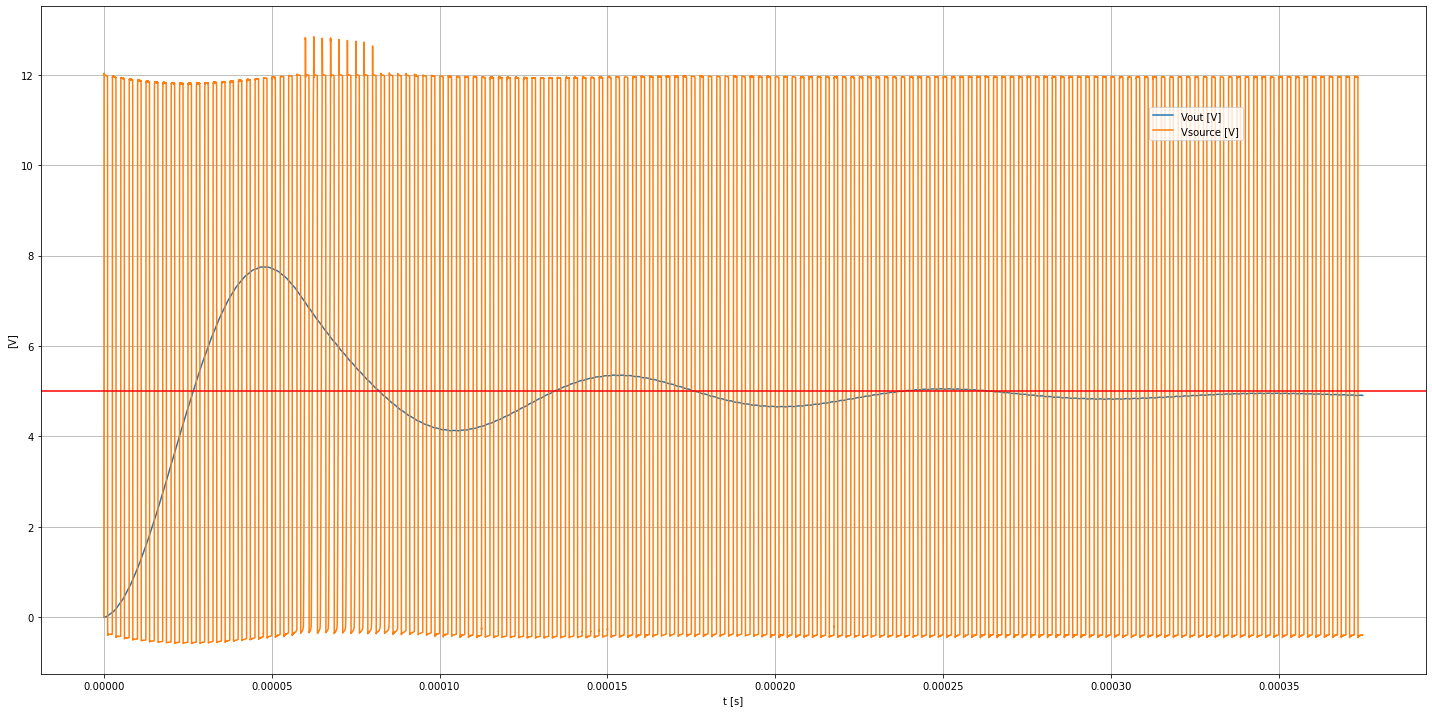

In [2]:
step_down(printdesignparameters=False)

## Onder belasting van de uitgang: 5uA

In [4]:
step_down(Iload = 5@u_A)

ratio = 0.4166666666666667 sr
RLoad = 1.25 Ω
period = 2.5000000000000004 μs
duty_cycle = 1.0416666666666667 μs
ripple_current = 1.5 A
L = 4.861111111111112 μH
Cout = 312.5 μF
Cint = -26.04166666666667 μF


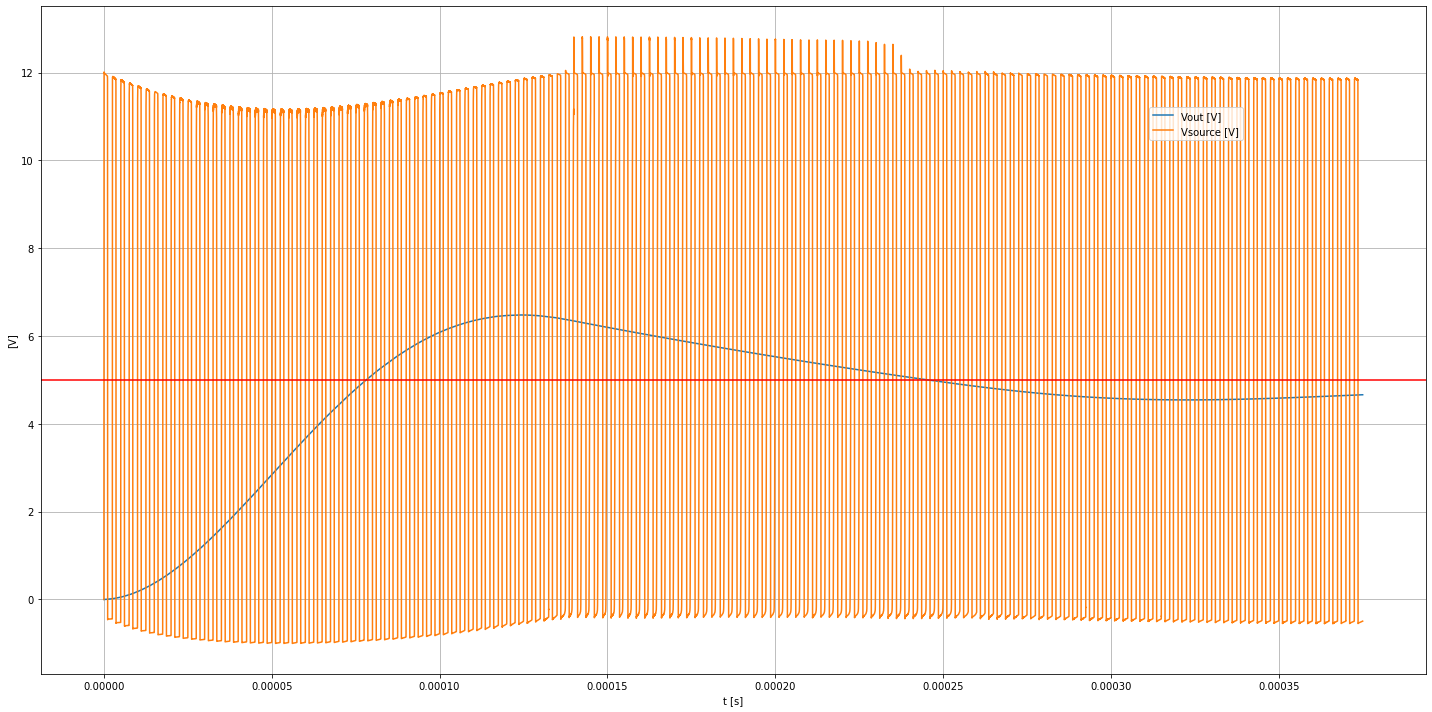

In [5]:
step_down(Iload = 5@u_A,printdesignparameters=False)